In [4]:
import pathlib

path=str(pathlib.Path().resolve())+"/"

In [5]:
import pandas as pd


wine = pd.read_csv(path+"winequality-red.csv")

In [6]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [7]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [8]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [9]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

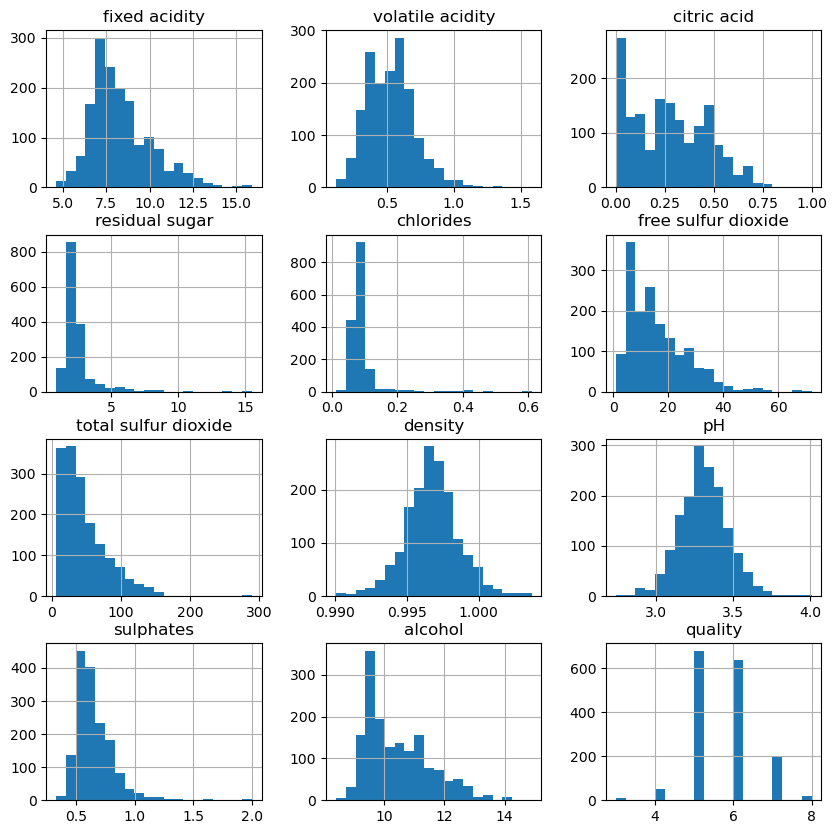

In [10]:
wine.hist(bins=20,figsize=(10,10))

<Axes: xlabel='alcohol', ylabel='volatile acidity'>

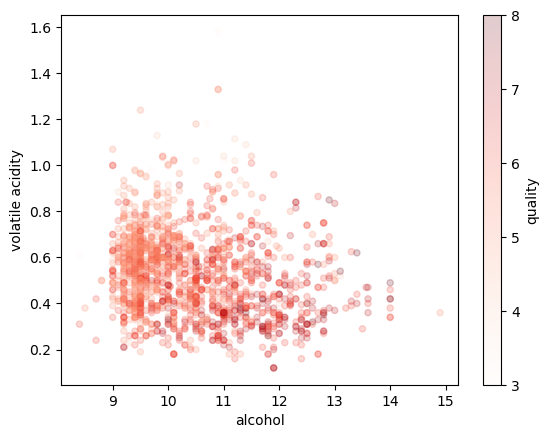

In [11]:
# Vemos que los que tienen más calidad en su mayoría rondan un nivel medio de Alcohol y un nivel Medio-Bajo de cítrico
wine.plot.scatter(y="volatile acidity",x="alcohol",alpha=0.2,c="quality",cmap="Reds")

# Boxplots para cada columna, desglosada por calidad

In [55]:
from matplotlib import pyplot as plt


def box_plot(types,by,dataFrame,deepColor,faceColor,color):
    num_cols = len(dataFrame.columns)
    num_rows = num_cols // 2 if num_cols % 2 == 0 else num_cols // 2 + 1
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, num_rows*5))
    for index,i in enumerate(types):
        ax = axs[index // 2, index % 2]
        if i != by:
            dataFrame.plot.box(by=by,column=i,ax=ax,
                  color=color,notch=True,vert=True,patch_artist=True,
                  # BORDE
                  boxprops=dict(edgecolor=deepColor,  facecolor=faceColor, linewidth=2),
                  # LINEA DE EXTREMO
                  capprops=dict(color=deepColor, linewidth=2),
                  # BORDE LINEA UNIÓN
                  whiskerprops=dict(color=deepColor,linewidth=1),
                  # PUNTOS
                  flierprops=dict(color=deepColor, markerfacecolor=faceColor, linestyle= "none", markeredgecolor="none", markersize=9),
                  # MEDIANA
                  medianprops=dict(color=deepColor),
                  # LINEA MEDIA
                  showmeans=True,)
    if num_cols % 2:
        fig.delaxes(axs[index // 2, 1])

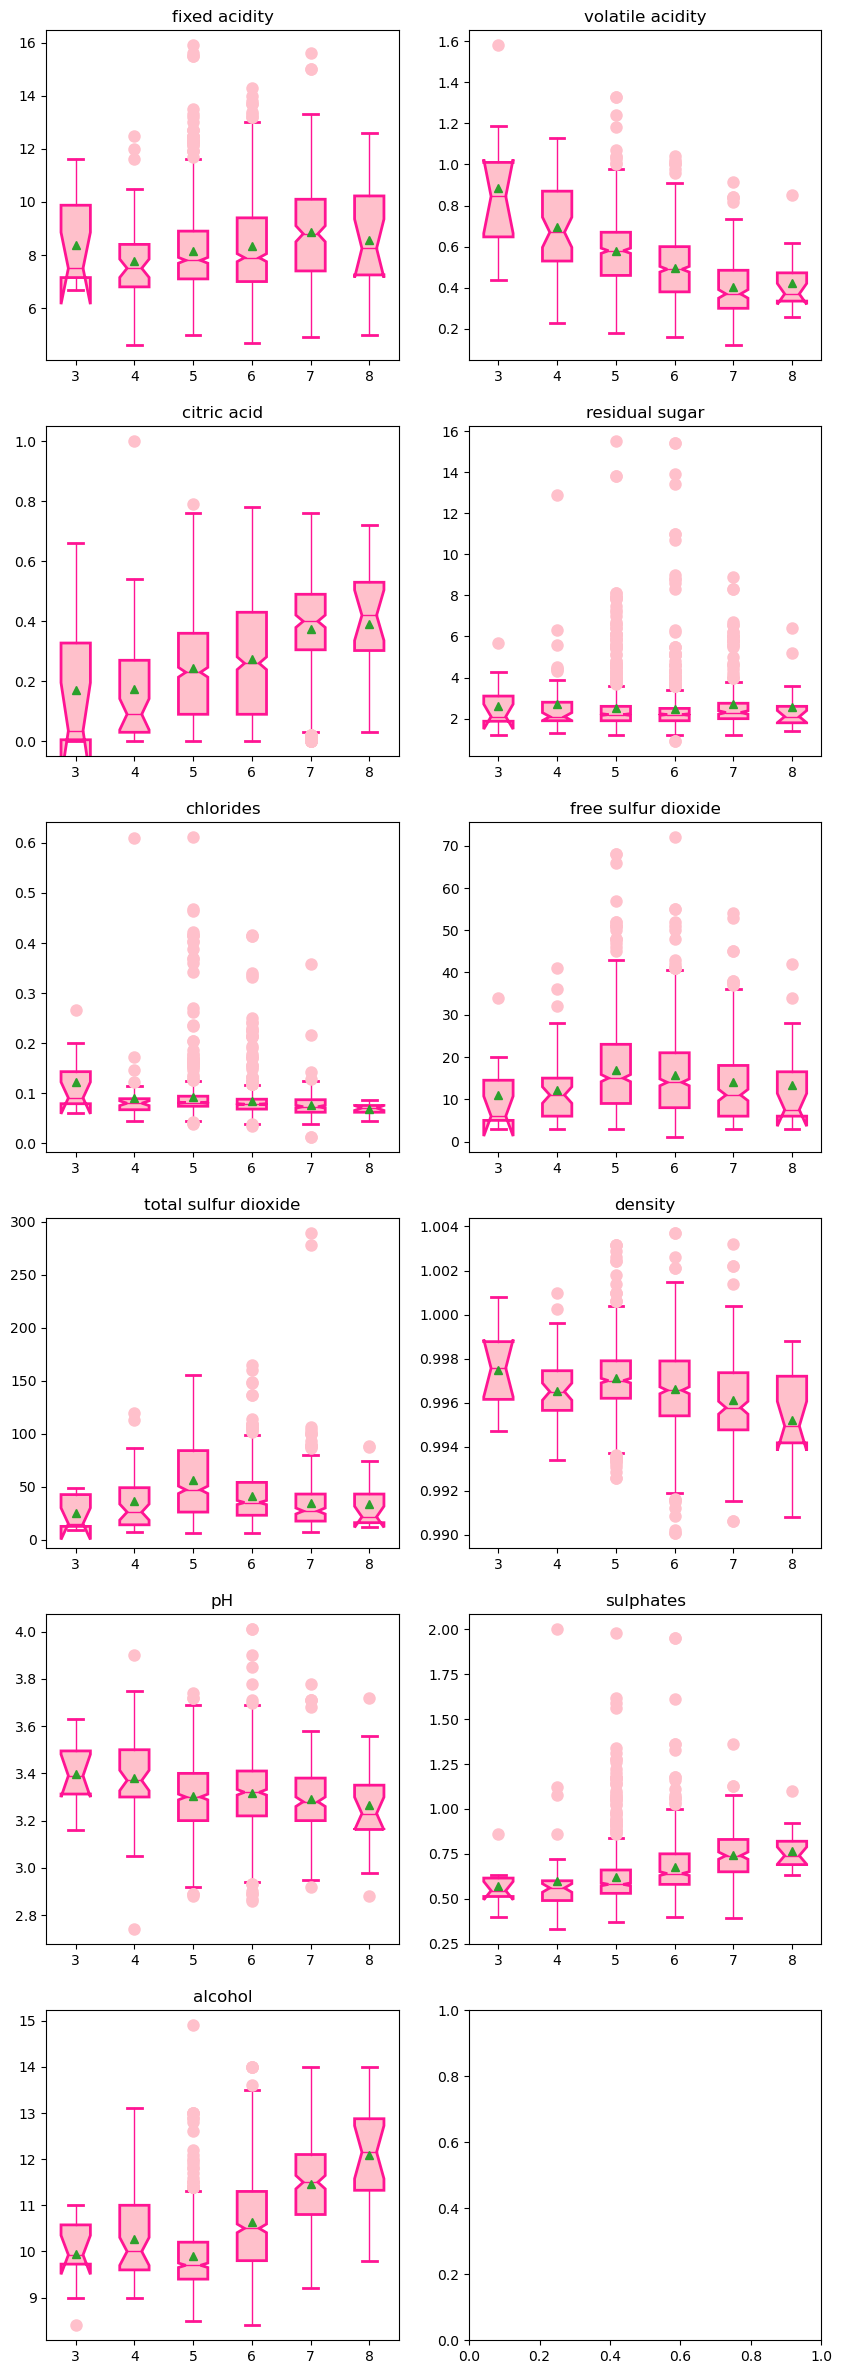

In [56]:
box_plot(types=wine.columns,by="quality",dataFrame=wine,deepColor="deeppink",faceColor="Pink",color="Pink")

In [ ]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots()
wine['quality']
im = ax.imshow(wine,cmap="Reds")
cbar = fig.colorbar(im,ax=ax,label="Alcohol")

x = wine['quality']
y = wine['alcohol']

#for i in range(len(y)):
#  for j in range(len(x)):
#    ax.text(j, i, f"A",ha="center")